In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import numpy as np

import matplotlib.pyplot as plt

import pickle as pkl
import pandas as pd
from pathlib import Path

from scipy import signal

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from tokeye.models.big_tf_unet.model_big_tf_unet import BigTFUNetModel
from tokeye.models.big_tf_unet.config_big_tf_unet import BigTFUNetConfig

from aemodes.utils.dataset import load_dataset

In [25]:
model_path = Path('/scratch/gpfs/nc1514/tokeye/model/big_tf_unet_251210.pt')
label_path = Path('/scratch/gpfs/nc1514/aemodes/data/co2_250_detector.pkl')

data_dirs = [
    Path('/scratch/gpfs/EKOLEMEN/d3d_fusion_data/'),
    Path('/scratch/gpfs/EKOLEMEN/hackathon/raw_h5_files/')
]

In [26]:
config = BigTFUNetConfig()
state_dict = torch.load(model_path, weights_only=True)
model = BigTFUNetModel(config)
model.load_state_dict(state_dict)
model.eval()

print("Model loaded")

Model loaded


In [27]:
train_dataset, valid_dataset = load_dataset(label_path)

In [28]:
available_train_shot_paths = {}
for shot in train_dataset.shots:
    for data_dir in data_dirs:
        if (data_dir / f'{shot}.h5').exists():
            available_train_shot_paths[shot] = data_dir / f'{shot}.h5'

available_valid_shot_paths = {}
for shot in valid_dataset.shots:
    for data_dir in data_dirs:
        if (data_dir / f'{shot}.h5').exists():
            available_valid_shot_paths[shot] = data_dir / f'{shot}.h5'

print(
    len(available_train_shot_paths), 
    len(available_valid_shot_paths),
    )

120 60


In [29]:
diagnostic = 'co2_density'
time_range = (0, 2000)

idx = 0
shot = train_dataset.shots[idx]
file = available_train_shot_paths[shot]
with pd.HDFStore(file) as store:
    data = store[diagnostic]
data = data.loc[time_range[0]:time_range[1]]
fs = len(data) / (data.index[-1] - data.index[0])

print(fs)
print(data.head())

1666.6675
                     r0            v1            v2            v3
Time [ms]                                                        
-0.000     2.546495e+12 -3.539883e+12 -1.527421e+12  5.204714e+12
 0.000     2.425803e+12 -3.527577e+12 -1.554595e+12  5.191896e+12
 0.001     2.454837e+12 -3.502967e+12 -1.529984e+12  5.118576e+12
 0.002     2.475332e+12 -3.466050e+12 -1.556646e+12  5.044230e+12
 0.002     2.411570e+12 -3.517323e+12 -1.532035e+12  5.019619e+12


In [ ]:
1666.6681 * 3 / 10

In [30]:
channel = 'r0'
up_factor, down_factor = 3, 10
resampled_data = signal.resample_poly(data[channel].values, up_factor, down_factor)
new_fs = fs * up_factor / down_factor

print(f"Original sampling rate: {fs} Hz")
print(f"Up factor: {up_factor}, Down factor: {down_factor}")
print(f"New sampling rate: {new_fs} Hz")
print(f"Resampled data shape: {resampled_data.shape}")

Original sampling rate: 1666.66748046875 Hz
Up factor: 3, Down factor: 10
New sampling rate: 500.000244140625 Hz
Resampled data shape: (1000001,)


In [31]:
# Create ShortTimeFFT object and compute spectrogram
nperseg, hop = 1024, 128
win = signal.get_window('hann', nperseg)
SFT = signal.ShortTimeFFT(win, hop=hop, fs=new_fs)
Sxx = SFT.spectrogram(resampled_data)[1:]
Sxx = np.log1p(Sxx)
print(Sxx.shape)

(512, 7820)


In [32]:
pkl_data = pkl.load(open(label_path, 'rb'))

In [33]:
original_data = pkl_data[1][idx][channel].T

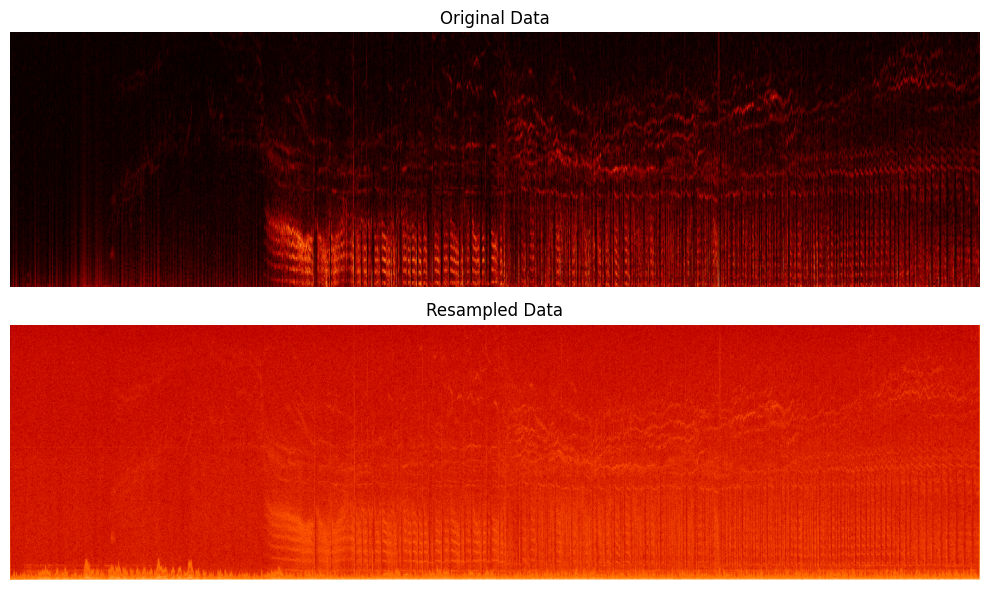

In [36]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6))

axes[0].imshow(
    original_data, 
    aspect='auto', 
    origin='lower', 
    cmap='gist_heat'
    )
axes[0].set_title('Original Data')
axes[0].axis('off')

axes[1].imshow(
    Sxx, 
    aspect='auto', 
    origin='lower', 
    cmap='gist_heat'
    )
axes[1].set_title('Resampled Data')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [37]:
labels = pkl_data[2][idx]

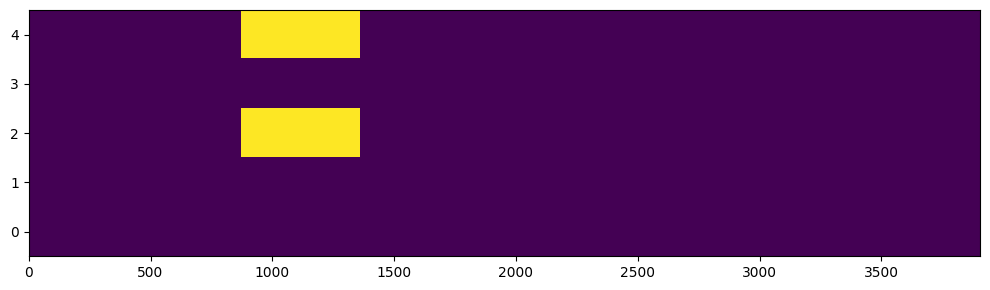

In [40]:
fig, axes = plt.subplots(1, 1, figsize=(10, 3))
axes.imshow(
    labels.T, 
    aspect='auto', 
    origin='lower', 
    interpolation='none',
    )
plt.tight_layout()
plt.show()

In [41]:
model_input = original_data
model_input = torch.from_numpy(model_input)
model_input = model_input.unsqueeze(0).unsqueeze(0).float()
model_input = (model_input - model_input.mean()) / model_input.std()
with torch.no_grad():
    model_output = model(model_input)[0]
    model_output = torch.sigmoid(model_output)

original_data_mode = model_output.squeeze(0).cpu().numpy()

model_input = Sxx
model_input = torch.from_numpy(model_input)
model_input = model_input.unsqueeze(0).unsqueeze(0).float()
model_input = (model_input - model_input.mean()) / model_input.std()
with torch.no_grad():
    model_output = model(model_input)[0]
    model_output = torch.sigmoid(model_output)

Sxx_mode = model_output.squeeze(0).cpu().numpy()

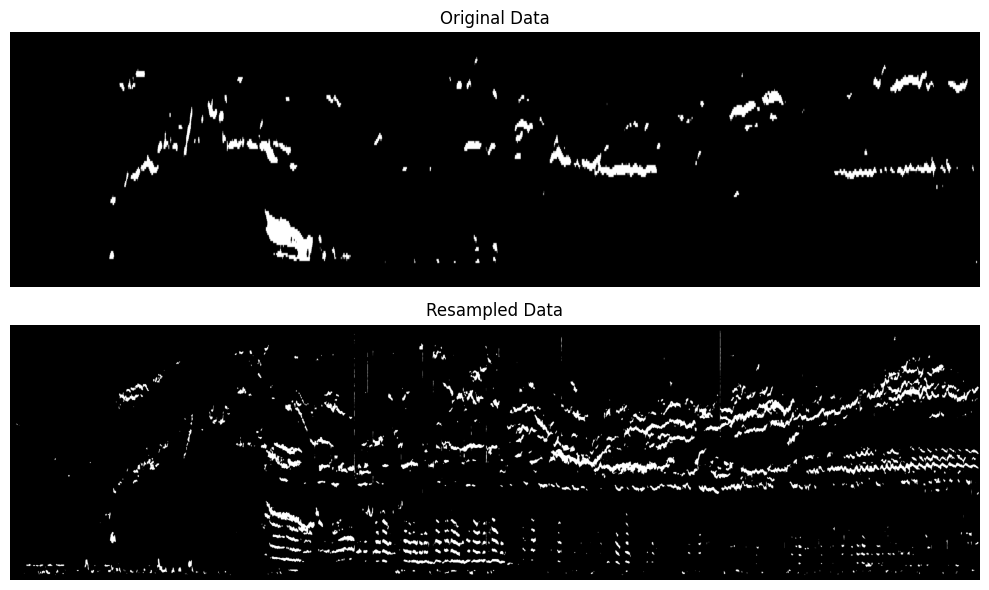

In [45]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6))

axes[0].imshow(
    original_data_mode[0] > 0.5, 
    aspect='auto', 
    origin='lower', 
    cmap='gist_heat'
    )
axes[0].set_title('Original Data')
axes[0].axis('off')

axes[1].imshow(
    Sxx_mode[0] > 0.4, 
    aspect='auto', 
    origin='lower', 
    cmap='gist_heat'
    )
axes[1].set_title('Resampled Data')
axes[1].axis('off')

plt.tight_layout()
plt.show()